In [2]:
import os

import numpy as np
%load_ext autoreload
%autoreload 2
from rdkit import Chem
import pandas as pd
from toolsets.file_io import get_file_list, readin_peak_list
import toolsets.spectra_operations as so
from toolsets.file_io import read_df, save_df
import toolsets.spectra_plotter as plotter
import toolsets.denoising_related_functions as drf
from toolsets.search import string_search,quick_search_values
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from toolsets.file_io import read_df, save_df
master_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/dilution_series_data'
figs_dir ='/Users/fanzhoukong/Documents/GitHub/Libgen_data/dilution_series_data/figs'
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                                    break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]
def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]
# reference_db_sorted = pd.read_csv('/Users/fanzhoukong/Documents/GitHub/Libgen_data/formula_db/formulaDB_sorted.csv')

# actual working

In [6]:
mrm_validated = read_df(os.path.join(master_dir, 'dilution_mapped_with_delta_S.csv'))
all_matched = read_df(os.path.join(master_dir, 'all_matched_20231026.csv'))

In [ ]:
import toolsets.denoising_related_functions as drf
import toolsets.spectra_plotter as plotter
polarity = []
for index, row in all_matched.iterrows():
    if row['reference_adduct'][-1]=='+':
        polarity.append('pos')
    else:
        polarity.append('neg')
all_matched['polarity']=polarity
concs = ['500 pmol', '200 pmol', '100 pmol','40 pmol', '10 pmol', '4 pmol', '2 pmol', '1 pmol', '0.4 pmol',
         '0.2 pmol', '0.1 pmol',
         '0.04 pmol', '0.02 pmol']
concs = [x.replace(' pmol', '') for x in concs]

In [8]:
all_matched['polarity'].value_counts()

polarity
pos    6885
neg    4938
Name: count, dtype: int64

In [9]:
count = []
label = []
conc_all =[]
for i in range(0, len(concs)):
    conc_temp = string_search(all_matched, 'conc', (i+1))
    pos_temp = string_search(conc_temp, 'polarity', 'pos')
    count.append(len(pos_temp))
    label.append('pos')
    conc_all.append(concs[i])
    neg_temp = string_search(conc_temp, 'polarity', 'neg')

    count.append(len(neg_temp))
    label.append('neg')
    conc_all.append(concs[i])

In [10]:
df = pd.DataFrame(zip(conc_all, label, count), columns=['conc', 'polarity', 'count'])

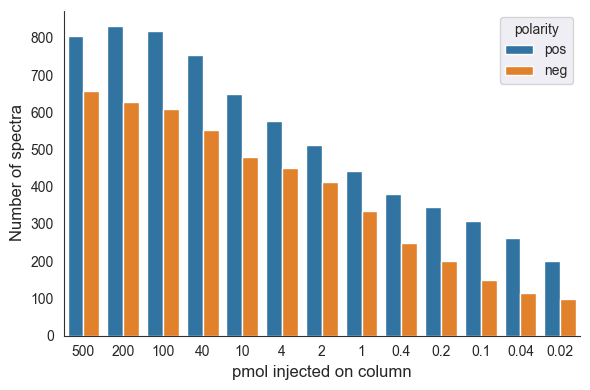

In [12]:

fig = plt.figure(figsize = (6, 4))#43
ax = fig.add_subplot()
sns.barplot(data=df, x="conc", y="count", hue="polarity")
ax.set_xlabel('pmol injected on column',size = 12)
ax.set_ylabel('Number of spectra', size = 12)
plt.grid(False)
ax.set_facecolor("white")

# plt.legend(facecolor='white', loc = 'upper left')
# ax.legend(facecolor='white', )
# plt.legend()
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
fig.tight_layout()
plt.savefig(os.path.join(figs_dir, 'n_spectra.png'))

In [14]:
msms_d = []
ei = []
for index, row in tqdm(all_matched.iterrows(), total = len(all_matched)):
    msms_d_temp = drf.spectral_denoising(row['msms'], row['reference_smiles'], row['reference_adduct'], max_allowed_deviation=0.005)
    msms_d.append(msms_d_temp)
    ei.append(drf.get_ei(msms_d_temp, row['msms'], pmz=row['reference_precursor_mz']))
all_matched['msms_denoised']=msms_d
all_matched['ei']=ei

100%|██████████| 11823/11823 [01:37<00:00, 121.72it/s]


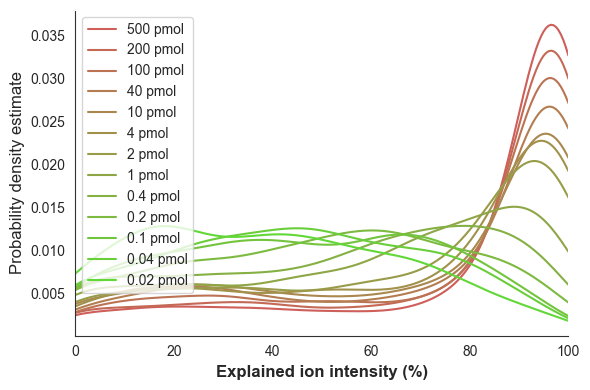

In [24]:
color2 = '#61D837'
color1 = '#CE5F5A'
color = get_color_gradient(color1, color2, 13)
fig = plt.figure(figsize = (6, 4))#43
ax = fig.add_subplot()
#
concs = ['500 pmol', '200 pmol', '100 pmol','40 pmol', '10 pmol', '4 pmol', '2 pmol', '1 pmol', '0.4 pmol',
         '0.2 pmol', '0.1 pmol',
         '0.04 pmol', '0.02 pmol']
for conc in range(1,14):
    matche_temp = string_search(all_matched, 'conc', conc)
    # sns.displot(matche_temp['ei'], kind="ecdf",label= concs[conc-1] , color = color[conc-1])
    sns.kdeplot(matche_temp['ei'], label= concs[conc-1] , color = color[conc-1], clip = [0,100])
plt.xlim(0, 100)
# plt.xlim(0, 100)
ax.set_xlabel('Explained ion intensity (%)'  , size = 12,fontdict={'weight': 'bold'})
ax.set_ylabel('Probability density estimate', size = 12)
# sns.lineplot(x = range(1,14), y = ns_means)
# sns.histplot(library_bad_quality['normalized_entropy'], label = 'low_quality')
# plt.vlines(x = 0.8, ymin=0, ymax=250, color = 'red')
plt.grid(False)
ax.set_facecolor("white")

plt.legend(facecolor='white', loc = 'upper left')
# ax.legend(facecolor='white', )
# plt.legend()
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
fig.tight_layout()
plt.savefig(os.path.join(figs_dir, 'ei_across_concs.png'))

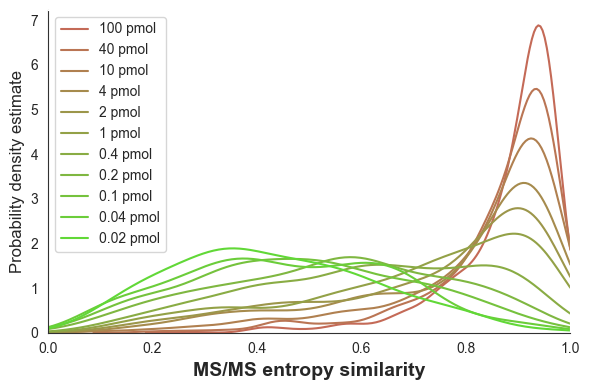

In [38]:
color2 = '#61D837'
color1 = '#CE5F5A'
color = get_color_gradient(color1, color2, 12)
fig = plt.figure(figsize = (6, 4))#43
ax = fig.add_subplot()
#
concs = [ '200 pmol', '100 pmol','40 pmol', '10 pmol', '4 pmol', '2 pmol', '1 pmol', '0.4 pmol',
         '0.2 pmol', '0.1 pmol',
         '0.04 pmol', '0.02 pmol']
for conc in range(1,13):
    matche_temp = string_search(mrm_validated, 'conc', conc)
    # sns.displot(matche_temp['ei'], kind="ecdf",label= concs[conc-1] , color = color[conc-1])
    sns.kdeplot(matche_temp['entropy_raw'], label= concs[conc-1] , color = color[conc-1], clip = [0,1])
plt.xlim(0, 1)
ax.set_xlabel('MS/MS entropy similarity',size = 14,  fontdict={'weight': 'bold'})
ax.set_ylabel('Probability density estimate', size = 12)
# sns.lineplot(x = range(1,14), y = ns_means)
# sns.histplot(library_bad_quality['normalized_entropy'], label = 'low_quality')
# plt.vlines(x = 0.8, ymin=0, ymax=250, color = 'red')
plt.grid(False)
ax.set_facecolor("white")

plt.legend(facecolor='white', loc = 'upper left')
# ax.legend(facecolor='white', )
# plt.legend()
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
fig.tight_layout()
plt.savefig(os.path.join(figs_dir, 'entropy_similarity_across_dilutions.png'))

In [41]:
unmapped = mrm_validated[mrm_validated['entropy_raw']<0.75]

In [42]:
import toolsets.denoising_related_functions as drf

In [44]:
library_peaks = []
entropy_raw =[]
entropy_denoised = []
for index, row in tqdm(mrm_validated.iterrows(), total = len(mrm_validated)):
    library_matched = string_search(library_high_quality, 'key', row['key'])
    library_peaks.append(library_matched.iloc[0]['msms_denoised'])
    entropy_raw.append(so.entropy_identity(row['msms'], library_matched.iloc[0]['msms_denoised'], pmz=row['reference_precursor_mz']))
    entropy_denoised.append(so.entropy_identity(row['msms_denoised'], library_matched.iloc[0]['msms_denoised'], pmz=row['reference_precursor_mz']))
mrm_validated['library_peaks']=library_peaks
mrm_validated['entropy_raw']=entropy_raw
mrm_validated['entropy_denoised']=entropy_denoised

100%|██████████| 6106/6106 [00:01<00:00, 3300.84it/s]


In [45]:
color2 = '#61D837'
color1 = '#CE5F5A'
color = get_color_gradient(color1, color2, 12)

#
concs = [ '200 pmol', '100 pmol','40 pmol', '10 pmol', '4 pmol', '2 pmol', '1 pmol', '0.4 pmol',
          '0.2 pmol', '0.1 pmol',
          '0.04 pmol', '0.02 pmol']

In [46]:
entropy_dyn = []
entropy_thres = []
entropy_reduce = []
for index, row in tqdm(mrm_validated.iterrows(), total =len(mrm_validated)):
    msms_dyn = drf.dnl_denoising(row['msms'])
    entropy_dyn.append(so.entropy_identity(row['library_peaks'], msms_dyn, pmz = row['reference_precursor_mz']))
    msms_thres = drf.threshold_denoising(row['msms'], 0.5)
    entropy_thres.append(so.entropy_identity(row['library_peaks'], msms_thres, pmz = row['reference_precursor_mz']))
    msms_reduce = drf.ms_reduce(row['msms'])
    entropy_reduce.append(so.entropy_identity(row['library_peaks'], msms_reduce, pmz = row['reference_precursor_mz']))
mrm_validated['entropy_dyn']=entropy_dyn
mrm_validated['entropy_thres']=entropy_thres
mrm_validated['entropy_reduce']=entropy_thres

100%|██████████| 6106/6106 [00:25<00:00, 240.81it/s]


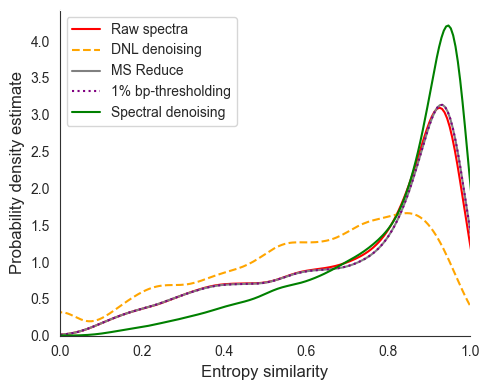

In [50]:
fig = plt.figure(figsize = (5, 4))#43
ax = fig.add_subplot()
sns.kdeplot(mrm_validated['entropy_raw'], label= 'Raw spectra' , color = 'red', cumulative=False)
sns.kdeplot(mrm_validated['entropy_dyn'], label= 'DNL denoising' , color = 'orange', cumulative=False, linestyle = '--')

sns.kdeplot(mrm_validated['entropy_reduce'], label= 'MS Reduce' , color = 'grey', cumulative=False)
sns.kdeplot(mrm_validated['entropy_thres'], label= '1% bp-thresholding' , color = 'purple', cumulative=False, linestyle = ':')
sns.kdeplot(mrm_validated['entropy_denoised'], label= 'Spectral denoising' , color = 'green',cumulative=False)
plt.xlim(0, 1)
plt.grid(False)
ax.set_xlabel('Entropy similarity',size = 12)
ax.set_ylabel('Probability density estimate', size = 12)
ax.set_facecolor("white")
plt.legend(facecolor='white')
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
# plt.legend()
fig.tight_layout()

plt.savefig(os.path.join(figs_dir,'method_benchmarking_raw.png'))

In [52]:
unmapped = mrm_validated[mrm_validated['entropy_raw']<0.75]

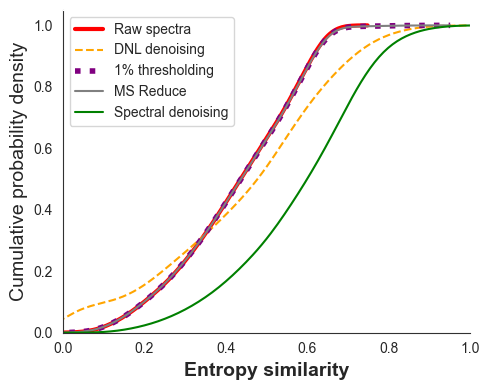

In [55]:
fig = plt.figure(figsize = (5, 4))#43
ax = fig.add_subplot()
sns.kdeplot(raw_raw['entropy_raw'], label= 'Raw spectra' , color = 'red', cumulative=True,lw=3 )
sns.kdeplot(raw_raw['entropy_dyn'], label= 'DNL denoising' , color = 'orange', cumulative=True, linestyle = '--',)


sns.kdeplot(raw_raw['entropy_thres'], label= '1% thresholding' , color = 'purple', cumulative=True, linestyle = ':',lw=4)
sns.kdeplot(raw_raw['entropy_reduce'], label= 'MS Reduce' , color = 'grey', cumulative=True)
sns.kdeplot(raw_raw['entropy_denoised'], label= 'Spectral denoising' , color = 'green',cumulative=True)
plt.xlim(0, 1)
plt.grid(False)
ax.set_xlabel('Entropy similarity',size = 14,  fontdict={'weight': 'bold'})
ax.set_ylabel('Cumulative probability density', size = 14)
ax.set_facecolor("white")
plt.legend(facecolor='white')
# plt.axvline(1)
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
# plt.legend()
fig.tight_layout()

plt.savefig(os.path.join(figs_dir,'unmapped_method_benchmarking.png'))

In [3]:
dilution_mapped = mrm_validated

done read in df


In [7]:
dilution_mapped['entropy_gain']=abs(dilution_mapped['entropy_denoised']-dilution_mapped['entropy_raw'])

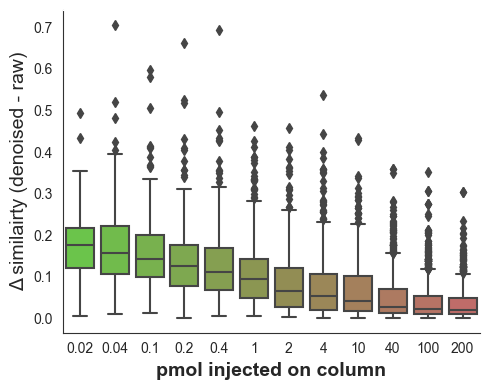

In [59]:
fig = plt.figure(figsize = (5, 4))#43
ax = fig.add_subplot()

color2 = '#61D837'
color1 = '#CE5F5A'
color = get_color_gradient(color1, color2, 12)
color_r = np.flip(color)
#
concs = [ '200 pmol', '100 pmol','40 pmol', '10 pmol', '4 pmol', '2 pmol', '1 pmol', '0.4 pmol',
          '0.2 pmol', '0.1 pmol',
          '0.04 pmol', '0.02 pmol']
conc_num=[200, 100, 40, 10, 4, 2, 1, 0.4, 0.2, 0.1, 0.04, 0.02]
conc_num_str = [str(x) for x in conc_num]
order_arr = np.flip(np.arange(2, 14))
sns.boxplot(x='conc', y='entropy_gain', data=dilution_mapped, palette=color_r,order=order_arr)
ax.set_xticklabels(np.flip(np.array(conc_num_str, dtype=str)))
plt.xlabel('pmol injected on column',size = 14,  fontdict={'weight': 'bold'})
plt.ylabel('Δ similairty (denoised - raw)',size = 14)
fig.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
plt.savefig(os.path.join(figs_dir,'delta_entropy_across_concentrations.png'))

In [253]:
mrm_validated

,reference_name,reference_mix,conc,ce,reference_mono_mass,reference_rt,reference_smiles,reference_formula,reference_adduct,reference_precursor_mz,...,mrm_raw_1,mrm_raw_2,mrm_raw_3,mrm_raw_intensity_sum,entropy_gain,entropy_fd,entropy_dnl,entropy_threshold,entropy_ms_reduce,ca_key
0,Myricetin,7,2,45,318.037567,4.69,O=c1c(O)c(-c2cc(O)c(O)c(O)c2)oc2cc(O)cc(O)c12,C15H10O8,[M-H]-,317.030291,...,"(109.02971, 0.20832103)","(151.00392, 0.13277158)","(163.00403, 0.08995913)",0.431052,0.004403,1.004521,0.836891,0.971616,0.731480,Myricetin[M-H]-
1,Patulin,3,2,45,154.026609,2.96,O=C1C=C2C(=CCOC2O)O1,C7H6O4,[M+H]+,155.033885,...,"(71.04945, 0.22168384)","(81.03378, 0.23490661)","(99.04439, 0.13764729)",0.594238,0.020257,1.021193,0.935426,0.972240,0.797983,Patulin[M+H]+
2,Griseofulvic Acid,3,2,45,338.055716,7.76,COc1cc(OC)c2c(c1Cl)OC1(C(=O)CC(=O)CC1C)C2=O,C16H15ClO6,[M+H]+,339.062992,...,"(69.03381, 0.40605593)","(255.04276, 0.36918643)","(111.04448, 0.04426855)",0.819511,0.042844,1.049830,0.856786,0.869386,0.812539,Griseofulvic Acid[M+H]+
3,Harpagoside,7,2,35,494.178812,6.89,CC1(OC(=O)C=Cc2ccccc2)CC(O)C2(O)C=COC(OC3OC(CO...,C24H30O11,[M+NH4]+,512.212635,...,"(149.06026, 0.32782775)","(167.07082, 0.32330945)","(93.0702, 0.11437138)",0.765509,0.031080,1.034285,0.908369,0.942391,0.783366,Harpagoside[M+NH4]+
4,Naringin,6,2,35,580.179206,5.66,CC1OC(OC2C(Oc3cc(O)c4c(c3)OC(c3ccc(O)cc3)CC4=O...,C27H32O14,[M+Cl]-,615.148608,...,"(271.06207, 0.44815758)","(151.00403, 0.23184936)","(459.11685, 0.069074556)",0.749081,0.031168,1.033697,0.755093,0.948406,0.778562,Naringin[M+Cl]-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6101,HARMALOL,9,13,45,200.094963,4.11,CC1=NCCc2c1[nH]c1cc(O)ccc21,C12H12N2O,[M+H]+,201.102239,...,"(160.07602, 0.2606779)","(184.07567, 0.07636531)","(68.04963, 0.07071416)",0.407757,0.201728,1.412519,0.567616,0.489014,0.701715,HARMALOL[M+H]+
6102,Monocrotaline,6,13,35,325.152537,3.02,CC1C(=O)OC2CCN3CC=C(COC(=O)C(C)(O)C1(C)O)C23,C16H23NO6,[M+H]+,326.159813,...,"(121.08915, 0.095249)","(237.13669, 0)","(120.08117, 0)",0.095249,0.134036,2.046080,0.372545,0.128132,0.297093,Monocrotaline[M+H]+
6103,Anisodamine Hydrobromide,3,13,65,305.162708,4.23,CN1C2CC(OC(=O)C(CO)c3ccccc3)CC1C(O)C2,C17H23NO4,[M+H]+,306.169984,...,"(140.10751, 0.25772324)","(91.05459, 0.12802821)","(122.09693, 0.08607061)",0.471822,0.035834,1.039755,0.539894,0.901373,0.616521,Anisodamine Hydrobromide[M+H]+
6104,Bergenin,3,13,35,328.079432,3.79,COc1c(O)cc2c(c1O)C1OC(CO)C(O)C(O)C1OC2=O,C14H16O9,[M-H]-,327.072156,...,"(192.00723, 0.2755693)","(234.01863, 0.20608404)","(193.01445, 0.21845837)",0.700112,0.134999,1.238991,0.699867,0.564868,0.436458,Bergenin[M-H]-


In [60]:
df = read_df(os.path.join(master_dir, 'absolute_conc_improvement_calculation.csv'))

done read in df


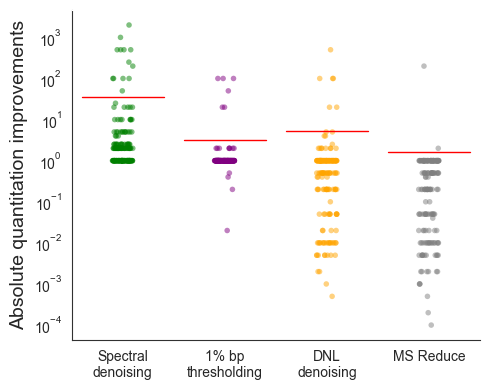

In [61]:
fig = plt.figure(figsize = (5, 4))#43
ax = fig.add_subplot()
p = sns.stripplot(x="method", y="improvement", data=df, size=4, color=".7",palette=['green', 'purple', 'orange', 'grey'],
                  alpha = 0.5)
wrap_labels(ax, 10)
p.set(yscale='log')

# plot the mean line
sns.boxplot(
            showmeans=True,
            meanline=True,
            meanprops={'color': 'red', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},

            # {'visible': True,palette=['green', 'purple', 'orange', 'grey'], alpha=0.7},
            whiskerprops={'visible': False},
            zorder=10,
            x="method",
            y="improvement",
            palette=['green', 'purple', 'orange', 'grey'],
            data=df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
p.set_xlabel('')


wrap_labels(p, 10)
# ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
p.set_ylabel('Absolute quantitation improvements', size = 14)
fig.tight_layout()
# plt.show()
ax.set_facecolor("white")
plt.savefig(os.path.join(figs_dir,'abs_conc_diff.png'))


# step 2: lets add some synthetic noise

In [13]:
import toolsets.denoising_related_functions as drf
raw_color =  'red'
dnl_color = 'orange'
mr_color = 'grey'
thr_color = 'purple'
sd_color = 'green'
import toolsets.chem_utils as cu
import matplotlib.pyplot as plt

# this is high high

In [4]:


import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
def add_statistics(sn1):
    library_se = []
    level = []
    entropy_raw = []
    entropy_loss = []
    for index, row in sn1.iterrows():
        se_temp =so.spectral_entropy(so.truncate_spectrum(row['library_peaks'], row['reference_adduct']))
        en_raw = so.entropy_identity(row['msms'], row['library_peaks'], pmz = row['reference_precursor_mz'])
        entropy_raw.append(en_raw)
        library_se.append(se_temp)
        entropy_loss.append(en_raw-row['entropy_cont_raw'])
        level.append(int(np.floor(se_temp)))
    sn1['library_entropy']=library_se
    sn1['level']=level
    sn1['entropy_raw']=entropy_raw
    sn1['entropy_loss']=entropy_loss
    sn1['entropy_gain']=abs(sn1['entropy_cont_denoised']-sn1['entropy_cont_raw'])
    se_level = []
    for index, row in sn1.iterrows():
        se_level.append(str(row['level'])+' to '+str(row['level']+1))
    sn1['Spectral entropy'] = se_level
    print('entropy gain for entropy 0-1 is: ',sn1[sn1['level']==0]['entropy_gain'].median())
    print('entropy gain for entropy 1-2 is: ',sn1[sn1['level']==1]['entropy_gain'].median())
    print('entropy gain for entropy 2-3 is: ',sn1[sn1['level']==2]['entropy_gain'].median())
    print('entropy gain for entropy 3-4 is: ',sn1[sn1['level']==3]['entropy_gain'].median())
    print('entropy gain for entropy 4-5 is: ',sn1[sn1['level']==4]['entropy_gain'].median())
    print('entropy loss for entropy 0-1 is: ',sn1[sn1['level']==0]['entropy_loss'].median())
    print('entropy loss for entropy 1-2 is: ',sn1[sn1['level']==1]['entropy_loss'].median())
    print('entropy loss for entropy 2-3 is: ',sn1[sn1['level']==2]['entropy_loss'].median())
    print('entropy loss for entropy 3-4 is: ',sn1[sn1['level']==3]['entropy_loss'].median())
    print('entropy loss for entropy 4-5 is: ',sn1[sn1['level']==4]['entropy_loss'].median())
    return(sn1)

In [133]:
sn1 = read_df(os.path.join(master_dir, 'synthetic_noise_sn_0.5_100.csv'))
msms_thres = []
entropy_thres = []
msms_reduce = []
entropy_reduce = []
msms_dnl = []
entropy_dnl = []
for index, row in tqdm(sn1.iterrows(), total = len(sn1)):
    msms_temp = drf.threshold_denoising(row['msms_cont'], threshold=1)
    entropy_thres.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.ms_reduce(row['msms_cont'])
    entropy_reduce.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.dnl_denoising(row['msms_cont'])
    entropy_dnl.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
sn1['entropy_thres']=entropy_thres
sn1['entropy_reduce']=entropy_reduce
sn1['entropy_dnl']=entropy_dnl

done read in df


100%|██████████| 6106/6106 [00:54<00:00, 111.07it/s]


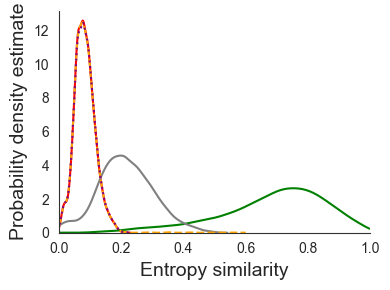

In [74]:
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1['entropy_cont_raw'], label= 'Raw spectra', color = raw_color)
sns.kdeplot(sn1['entropy_cont_denoised'], label= 'Spectral denoising' ,color= sd_color)

sns.kdeplot(sn1['entropy_reduce'], label= 'MS Reduce' ,color= mr_color)
sns.kdeplot(sn1['entropy_dnl'], label= 'DNL denoising' ,color= dnl_color,linestyle = '--')
sns.kdeplot(sn1['entropy_thres'], label= '1% bp thresholding' ,color= thr_color, linestyle = ':')
ax.set_xlabel('Entropy similarity',size = 14)
ax.set_ylabel('Probability density estimate', size = 14)
ax.set_facecolor("white")
ax.set_xlim(0,1)
plt.legend([],[], frameon=False)
# ax.tick_params(labelsize=6)
fig.tight_layout()
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
plt.savefig(os.path.join(figs_dir, 'high_high_no_legend.png'))

In [135]:
sn1 = add_statistics(sn1)

entropy gain for entropy 0-1 is:  0.6475309804081918
entropy gain for entropy 1-2 is:  0.6659870892763138
entropy gain for entropy 2-3 is:  0.6269666440784931
entropy gain for entropy 3-4 is:  0.5870610512793064
entropy gain for entropy 4-5 is:  0.5936419740319252
entropy loss for entropy 0-1 is:  0.6225732266902925
entropy loss for entropy 1-2 is:  0.7087710313498974
entropy loss for entropy 2-3 is:  0.7508723810315132
entropy loss for entropy 3-4 is:  0.7438865378499031
entropy loss for entropy 4-5 is:  0.7385565340518951


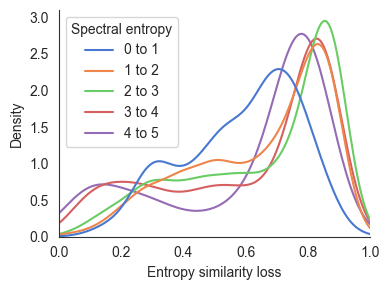

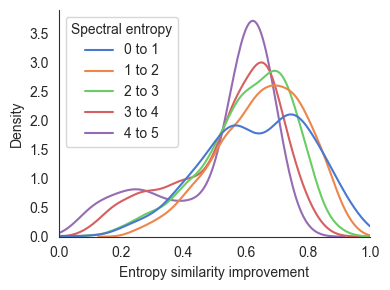

In [136]:
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1, x="entropy_loss", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False,
            hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5']
            )
# plt.legend( facecolor = 'white')
# sns.move_legend(ax, "upper left")
ax.set_xlabel('Entropy similarity loss')
fig.tight_layout()
ax.set_xlim(0,1)
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'high_high_entropy_loss.png'))
# ax.set_ylabel('Probability density estimate')

fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
# plt.legend(title='Spectral entropy', loc='upper right', labels=['0-1', '1-2','2-3','3-4','4-5'])
ax.set_xlabel('Entropy similarity improvement')
ax.set_xlim(0,1)
sns.kdeplot(sn1, x="entropy_gain", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False, hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5'])

# sns.kdeplot(sn1, x="entropy_gain", hue="level", multiple="layer",palette="pastel",common_norm=False,)
# plt.legend(title='Spectral entropy', loc='upper left', labels=['0-1', '1-2','2-3','3-4','4-5'], facecolor = 'white')
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'high_high_entropy_gain.png'))

# this is high middle

In [137]:
sn1 = read_df(os.path.join(master_dir, 'synthetic_noise_sn_0.5_10.csv'))
# sn1 = add_statistics(sn1)
msms_thres = []
entropy_thres = []
msms_reduce = []
entropy_reduce = []
msms_dnl = []
entropy_dnl = []
for index, row in tqdm(sn1.iterrows(), total = len(sn1)):
    msms_temp = drf.threshold_denoising(row['msms_cont'], threshold=1)
    entropy_thres.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.ms_reduce(row['msms_cont'])
    entropy_reduce.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.dnl_denoising(row['msms_cont'])
    entropy_dnl.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
sn1['entropy_thres']=entropy_thres
sn1['entropy_reduce']=entropy_reduce
sn1['entropy_dnl']=entropy_dnl
sn1 = add_statistics(sn1)



done read in df


100%|██████████| 6106/6106 [00:42<00:00, 144.55it/s]


entropy gain for entropy 0-1 is:  0.49752882122993475
entropy gain for entropy 1-2 is:  0.49923185259103786
entropy gain for entropy 2-3 is:  0.4458765834569931
entropy gain for entropy 3-4 is:  0.3931063413619995
entropy gain for entropy 4-5 is:  0.3772777616977692
entropy loss for entropy 0-1 is:  0.4680990278720857
entropy loss for entropy 1-2 is:  0.5342834964394569
entropy loss for entropy 2-3 is:  0.5332596600055695
entropy loss for entropy 3-4 is:  0.496400386095047
entropy loss for entropy 4-5 is:  0.497844934463501


In [ ]:
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1['entropy_cont_raw'], label= 'Raw spectra', color = raw_color)
sns.kdeplot(sn1['entropy_cont_denoised'], label= 'Spectral denoising' ,color= sd_color)

sns.kdeplot(sn1['entropy_reduce'], label= 'MS Reduce' ,color= mr_color)
sns.kdeplot(sn1['entropy_dnl'], label= 'DNL denoising' ,color= dnl_color,linestyle = '--')
sns.kdeplot(sn1['entropy_thres'], label= '1% bp thresholding' ,color= thr_color, linestyle = ':')
ax.set_xlabel('Entropy similarity',size = 14)
ax.set_ylabel('Probability density estimate', size = 14)
ax.set_facecolor("white")
ax.set_xlim(0,1)
plt.legend([],[], frameon=False)
# ax.tick_params(labelsize=6)
fig.tight_layout()
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
plt.savefig(os.path.join(figs_dir, 'high_middle_no_legend.png'))

entropy gain for entropy 0-1 is:  0.49752882122993475
entropy gain for entropy 1-2 is:  0.49923185259103786
entropy gain for entropy 2-3 is:  0.4458765834569931
entropy gain for entropy 3-4 is:  0.3931063413619995
entropy gain for entropy 4-5 is:  0.3772777616977692
entropy loss for entropy 0-1 is:  0.4680990278720857
entropy loss for entropy 1-2 is:  0.5342834964394569
entropy loss for entropy 2-3 is:  0.5332596600055695
entropy loss for entropy 3-4 is:  0.496400386095047
entropy loss for entropy 4-5 is:  0.497844934463501


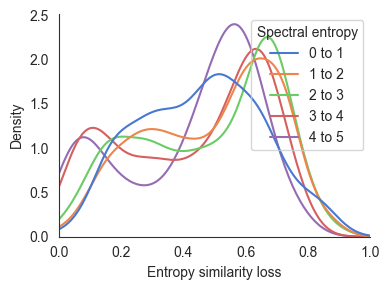

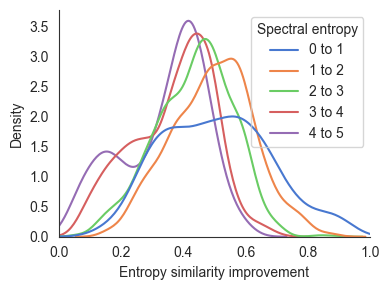

In [138]:
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1, x="entropy_loss", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False,
            hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5']
            )
# plt.legend( facecolor = 'white')
# sns.move_legend(ax, "upper left")
ax.set_xlabel('Entropy similarity loss')
fig.tight_layout()
ax.set_xlim(0,1)
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'high_middle_entropy_loss.png'))
# ax.set_ylabel('Probability density estimate')

fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
# plt.legend(title='Spectral entropy', loc='upper right', labels=['0-1', '1-2','2-3','3-4','4-5'])
ax.set_xlabel('Entropy similarity improvement')
ax.set_xlim(0,1)
sns.kdeplot(sn1, x="entropy_gain", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False, hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5'])

# sns.kdeplot(sn1, x="entropy_gain", hue="level", multiple="layer",palette="pastel",common_norm=False,)
# plt.legend(title='Spectral entropy', loc='upper left', labels=['0-1', '1-2','2-3','3-4','4-5'], facecolor = 'white')
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'high_middle_entropy_gain.png'))

# lets do high low

done read in df


100%|██████████| 6106/6106 [00:40<00:00, 151.92it/s]


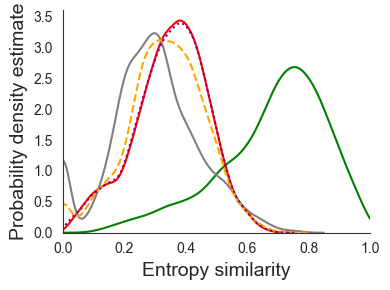

In [16]:
sn1 = read_df(os.path.join(master_dir, 'synthetic_noise_sn_0.5_2.csv'))
msms_thres = []
entropy_thres = []
msms_reduce = []
entropy_reduce = []
msms_dnl = []
entropy_dnl = []
for index, row in tqdm(sn1.iterrows(), total = len(sn1)):
    msms_temp = drf.threshold_denoising(row['msms_cont'], threshold=1)
    entropy_thres.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.ms_reduce(row['msms_cont'])
    entropy_reduce.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.dnl_denoising(row['msms_cont'])
    entropy_dnl.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
sn1['entropy_thres']=entropy_thres
sn1['entropy_reduce']=entropy_reduce
sn1['entropy_dnl']=entropy_dnl
# sn1 = add_statistics(sn1)
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1['entropy_cont_raw'], label= 'Raw spectra', color = raw_color)
sns.kdeplot(sn1['entropy_cont_denoised'], label= 'Spectral denoising' ,color= sd_color)

sns.kdeplot(sn1['entropy_reduce'], label= 'MS Reduce' ,color= mr_color)
sns.kdeplot(sn1['entropy_dnl'], label= 'DNL denoising' ,color= dnl_color,linestyle = '--')
sns.kdeplot(sn1['entropy_thres'], label= '1% bp thresholding' ,color= thr_color, linestyle = ':')
ax.set_xlabel('Entropy similarity',size = 14)
ax.set_ylabel('Probability density estimate', size = 14)
ax.set_facecolor("white")
ax.set_xlim(0,1)
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.legend([],[], frameon=False)
# ax.tick_params(labelsize=6)

fig.tight_layout()
plt.savefig(os.path.join(figs_dir, 'high_low_no_legend.png'))

In [140]:
sn1 = add_statistics(sn1)

entropy gain for entropy 0-1 is:  0.40680602192878723
entropy gain for entropy 1-2 is:  0.3925885334610939
entropy gain for entropy 2-3 is:  0.325590118765831
entropy gain for entropy 3-4 is:  0.26615580916404724
entropy gain for entropy 4-5 is:  0.24338936805725098
entropy loss for entropy 0-1 is:  0.3562054038047791
entropy loss for entropy 1-2 is:  0.4144383370876312
entropy loss for entropy 2-3 is:  0.39915262162685394
entropy loss for entropy 3-4 is:  0.3526528924703598
entropy loss for entropy 4-5 is:  0.35543882846832275


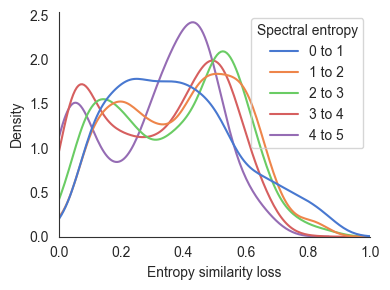

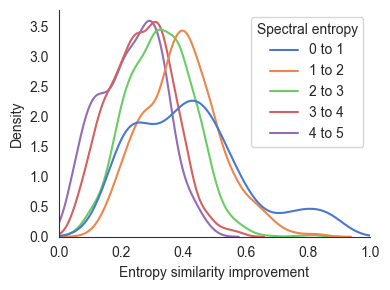

In [141]:
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1, x="entropy_loss", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False,
            hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5']
            )
# plt.legend( facecolor = 'white')
# sns.move_legend(ax, "upper left")
ax.set_xlabel('Entropy similarity loss')
fig.tight_layout()
ax.set_xlim(0,1)
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'high_low_entropy_loss.png'))
# ax.set_ylabel('Probability density estimate')

fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
# plt.legend(title='Spectral entropy', loc='upper right', labels=['0-1', '1-2','2-3','3-4','4-5'])
ax.set_xlabel('Entropy similarity improvement')
ax.set_xlim(0,1)
sns.kdeplot(sn1, x="entropy_gain", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False, hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5'])

# sns.kdeplot(sn1, x="entropy_gain", hue="level", multiple="layer",palette="pastel",common_norm=False,)
# plt.legend(title='Spectral entropy', loc='upper left', labels=['0-1', '1-2','2-3','3-4','4-5'], facecolor = 'white')
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'high_low_entropy_gain.png'))

# middle high

In [142]:
sn1 = read_df(os.path.join(master_dir, 'synthetic_noise_sn_0.2_100.csv'))
msms_thres = []
entropy_thres = []
msms_reduce = []
entropy_reduce = []
msms_dnl = []
entropy_dnl = []
for index, row in tqdm(sn1.iterrows(), total = len(sn1)):
    msms_temp = drf.threshold_denoising(row['msms_cont'], threshold=1)
    entropy_thres.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.ms_reduce(row['msms_cont'])
    entropy_reduce.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.dnl_denoising(row['msms_cont'])
    entropy_dnl.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
sn1['entropy_thres']=entropy_thres
sn1['entropy_reduce']=entropy_reduce
sn1['entropy_dnl']=entropy_dnl
sn1 = add_statistics(sn1)


done read in df


100%|██████████| 6106/6106 [00:53<00:00, 113.36it/s]


entropy gain for entropy 0-1 is:  0.7289352566003799
entropy gain for entropy 1-2 is:  0.7552101910114288
entropy gain for entropy 2-3 is:  0.7344704400748014
entropy gain for entropy 3-4 is:  0.6814566291868687
entropy gain for entropy 4-5 is:  0.6548981964588166
entropy loss for entropy 0-1 is:  0.6213080659508706
entropy loss for entropy 1-2 is:  0.711285762488842
entropy loss for entropy 2-3 is:  0.7548491880297661
entropy loss for entropy 3-4 is:  0.7430427558720112
entropy loss for entropy 4-5 is:  0.73621866106987


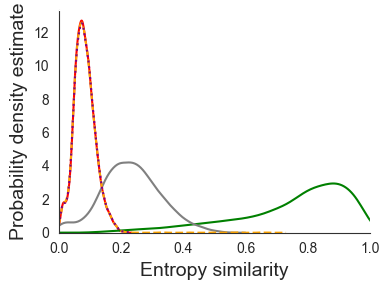

In [84]:
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1['entropy_cont_raw'], label= 'Raw spectra', color = raw_color)
sns.kdeplot(sn1['entropy_cont_denoised'], label= 'Spectral denoising' ,color= sd_color)

sns.kdeplot(sn1['entropy_reduce'], label= 'MS Reduce' ,color= mr_color)
sns.kdeplot(sn1['entropy_dnl'], label= 'DNL denoising' ,color= dnl_color,linestyle = '--')
sns.kdeplot(sn1['entropy_thres'], label= '1% bp thresholding' ,color= thr_color, linestyle = ':')
ax.set_xlabel('Entropy similarity',size = 14)
ax.set_ylabel('Probability density estimate', size = 14)
ax.set_facecolor("white")
ax.set_xlim(0,1)
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
plt.legend([],[], frameon=False)
# ax.tick_params(labelsize=6)

fig.tight_layout()
plt.savefig(os.path.join(figs_dir, 'middle_high_no_legend.png'))

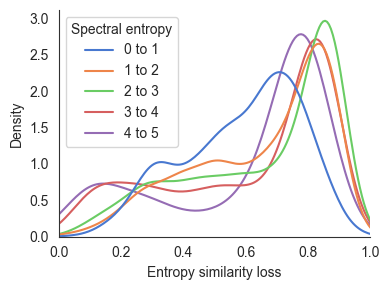

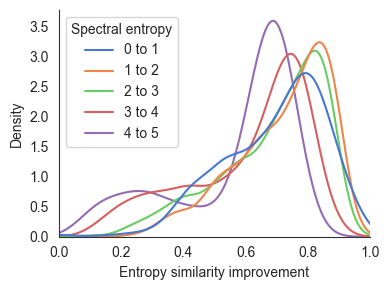

In [143]:
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1, x="entropy_loss", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False,
            hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5']
            )
# plt.legend( facecolor = 'white')
# sns.move_legend(ax, "upper left")
ax.set_xlabel('Entropy similarity loss')
fig.tight_layout()
ax.set_xlim(0,1)
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'middle_high_entropy_loss.png'))
# ax.set_ylabel('Probability density estimate')

fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
# plt.legend(title='Spectral entropy', loc='upper right', labels=['0-1', '1-2','2-3','3-4','4-5'])
ax.set_xlabel('Entropy similarity improvement')
ax.set_xlim(0,1)
sns.kdeplot(sn1, x="entropy_gain", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False, hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5'])

# sns.kdeplot(sn1, x="entropy_gain", hue="level", multiple="layer",palette="pastel",common_norm=False,)
# plt.legend(title='Spectral entropy', loc='upper left', labels=['0-1', '1-2','2-3','3-4','4-5'], facecolor = 'white')
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'middle_high_entropy_gain.png'))

# middle middle

In [144]:
sn1 = read_df(os.path.join(master_dir, 'synthetic_noise_sn_0.2_10.csv'))
msms_thres = []
entropy_thres = []
msms_reduce = []
entropy_reduce = []
msms_dnl = []
entropy_dnl = []
for index, row in tqdm(sn1.iterrows(), total = len(sn1)):
    msms_temp = drf.threshold_denoising(row['msms_cont'], threshold=1)
    entropy_thres.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.ms_reduce(row['msms_cont'])
    entropy_reduce.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.dnl_denoising(row['msms_cont'])
    entropy_dnl.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
sn1['entropy_thres']=entropy_thres
sn1['entropy_reduce']=entropy_reduce
sn1['entropy_dnl']=entropy_dnl
sn1 = add_statistics(sn1)

done read in df


100%|██████████| 6106/6106 [00:46<00:00, 132.63it/s]


entropy gain for entropy 0-1 is:  0.5415941774845123
entropy gain for entropy 1-2 is:  0.5567692816257477
entropy gain for entropy 2-3 is:  0.5067655444145203
entropy gain for entropy 3-4 is:  0.4341750368475914
entropy gain for entropy 4-5 is:  0.4019867181777954
entropy loss for entropy 0-1 is:  0.4424117803573609
entropy loss for entropy 1-2 is:  0.5115476548671722
entropy loss for entropy 2-3 is:  0.5016812384128571
entropy loss for entropy 3-4 is:  0.4574867337942124
entropy loss for entropy 4-5 is:  0.4545115530490875


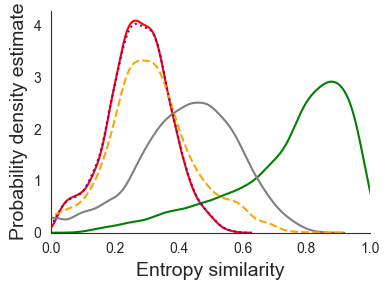

In [88]:
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1['entropy_cont_raw'], label= 'Raw spectra', color = raw_color)
sns.kdeplot(sn1['entropy_cont_denoised'], label= 'Spectral denoising' ,color= sd_color)

sns.kdeplot(sn1['entropy_reduce'], label= 'MS Reduce' ,color= mr_color)
sns.kdeplot(sn1['entropy_dnl'], label= 'DNL denoising' ,color= dnl_color,linestyle = '--')
sns.kdeplot(sn1['entropy_thres'], label= '1% bp thresholding' ,color= thr_color, linestyle = ':')
ax.set_xlabel('Entropy similarity',size = 14)
ax.set_ylabel('Probability density estimate', size = 14)
ax.set_facecolor("white")
ax.set_xlim(0,1)
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
plt.legend([],[], frameon=False)
# ax.tick_params(labelsize=6)

fig.tight_layout()
plt.savefig(os.path.join(figs_dir, 'middle_middle_no_legend.png'))

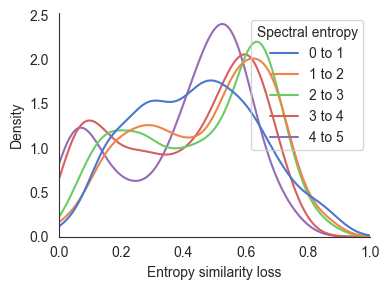

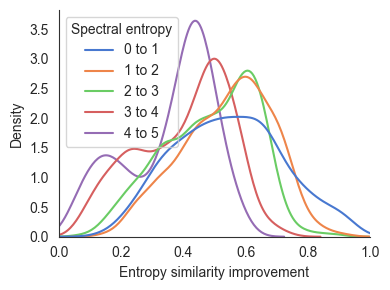

In [132]:
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1, x="entropy_loss", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False,
            hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5']
            )
# plt.legend( facecolor = 'white')
# sns.move_legend(ax, "upper left")
ax.set_xlabel('Entropy similarity loss')
fig.tight_layout()
ax.set_xlim(0,1)
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'middle_middle_entropy_loss.png'))
# ax.set_ylabel('Probability density estimate')

fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
# plt.legend(title='Spectral entropy', loc='upper right', labels=['0-1', '1-2','2-3','3-4','4-5'])
ax.set_xlabel('Entropy similarity improvement')
ax.set_xlim(0,1)
sns.kdeplot(sn1, x="entropy_gain", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False, hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5'])

# sns.kdeplot(sn1, x="entropy_gain", hue="level", multiple="layer",palette="pastel",common_norm=False,)
# plt.legend(title='Spectral entropy', loc='upper left', labels=['0-1', '1-2','2-3','3-4','4-5'], facecolor = 'white')
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'middle_middle_entropy_gain.png'))

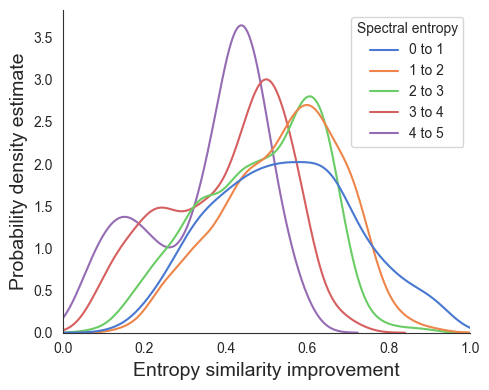

In [128]:
fig = plt.figure(figsize = (5, 4))#43
ax = fig.add_subplot()
# plt.legend(title='Spectral entropy', loc='upper right', labels=['0-1', '1-2','2-3','3-4','4-5'])

ax.set_xlim(0,1)
sns.kdeplot(sn1, x="entropy_gain", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False, hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5'])
sns.move_legend(ax, "upper right")
# legend = plt.legend()
# frame = legend.get_frame()
# frame.set_facecolor('white')
ax.set_ylabel('Probability density estimate', size = 14)
ax.set_xlabel('Entropy similarity improvement', size = 14)
# sns.kdeplot(sn1, x="entropy_gain", hue="level", multiple="layer",palette="pastel",common_norm=False,)
# plt.legend(title='Spectral entropy', loc='upper left', labels=['0-1', '1-2','2-3','3-4','4-5'], facecolor = 'white')
plt.grid(False)
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir,'middle_middle_entropy_gain_enlarged.png'))

# middle low

In [145]:
sn1 = read_df(os.path.join(master_dir, 'synthetic_noise_sn_0.2_2.csv'))
msms_thres = []
entropy_thres = []
msms_reduce = []
entropy_reduce = []
msms_dnl = []
entropy_dnl = []
for index, row in tqdm(sn1.iterrows(), total = len(sn1)):
    msms_temp = drf.threshold_denoising(row['msms_cont'], threshold=0.5)
    entropy_thres.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.ms_reduce(row['msms_cont'])
    entropy_reduce.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.dnl_denoising(row['msms_cont'])
    entropy_dnl.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
sn1['entropy_thres']=entropy_thres
sn1['entropy_reduce']=entropy_reduce
sn1['entropy_dnl']=entropy_dnl
sn1 = add_statistics(sn1)

done read in df


100%|██████████| 6106/6106 [00:43<00:00, 140.82it/s]


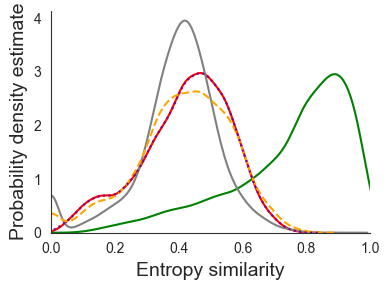

In [93]:

fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1['entropy_cont_raw'], label= 'Raw spectra', color = raw_color)
sns.kdeplot(sn1['entropy_cont_denoised'], label= 'Spectral denoising' ,color= sd_color)

sns.kdeplot(sn1['entropy_reduce'], label= 'MS Reduce' ,color= mr_color)
sns.kdeplot(sn1['entropy_dnl'], label= 'DNL denoising' ,color= dnl_color,linestyle = '--')
sns.kdeplot(sn1['entropy_thres'], label= '1% bp thresholding' ,color= thr_color, linestyle = ':')
ax.set_xlabel('Entropy similarity',size = 14)
ax.set_ylabel('Probability density estimate', size = 14)
ax.set_facecolor("white")
ax.set_xlim(0,1)
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
plt.legend([],[], frameon=False)
# ax.tick_params(labelsize=6)

fig.tight_layout()
plt.savefig(os.path.join(figs_dir, 'middle_low_no_legend.png'))

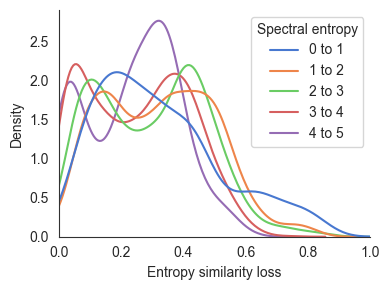

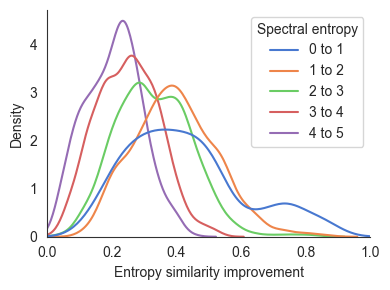

In [147]:
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1, x="entropy_loss", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False,
            hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5']
            )
# plt.legend( facecolor = 'white')
# sns.move_legend(ax, "upper left")
ax.set_xlabel('Entropy similarity loss')
fig.tight_layout()
ax.set_xlim(0,1)
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'middle_low_entropy_loss.png'))
# ax.set_ylabel('Probability density estimate')

fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
# plt.legend(title='Spectral entropy', loc='upper right', labels=['0-1', '1-2','2-3','3-4','4-5'])
ax.set_xlabel('Entropy similarity improvement')
ax.set_xlim(0,1)
sns.kdeplot(sn1, x="entropy_gain", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False, hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5'])

# sns.kdeplot(sn1, x="entropy_gain", hue="level", multiple="layer",palette="pastel",common_norm=False,)
# plt.legend(title='Spectral entropy', loc='upper left', labels=['0-1', '1-2','2-3','3-4','4-5'], facecolor = 'white')
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'middle_low_entropy_gain.png'))

# low high

In [148]:
sn1 = read_df(os.path.join(master_dir, 'synthetic_noise_sn_0.1_100.csv'))
msms_thres = []
entropy_thres = []
msms_reduce = []
entropy_reduce = []
msms_dnl = []
entropy_dnl = []
for index, row in tqdm(sn1.iterrows(), total = len(sn1)):
    msms_temp = drf.threshold_denoising(row['msms_cont'], threshold=0.5)
    entropy_thres.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.ms_reduce(row['msms_cont'])
    entropy_reduce.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.dnl_denoising(row['msms_cont'])
    entropy_dnl.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
sn1['entropy_thres']=entropy_thres
sn1['entropy_reduce']=entropy_reduce
sn1['entropy_dnl']=entropy_dnl
sn1 = add_statistics(sn1)

done read in df


100%|██████████| 6106/6106 [00:52<00:00, 115.21it/s]


entropy gain for entropy 0-1 is:  0.7389355450868607
entropy gain for entropy 1-2 is:  0.7799250409007072
entropy gain for entropy 2-3 is:  0.7712252102792264
entropy gain for entropy 3-4 is:  0.7227254025638103
entropy gain for entropy 4-5 is:  0.6931398585438728
entropy loss for entropy 0-1 is:  0.6252556890249252
entropy loss for entropy 1-2 is:  0.7121525891125202
entropy loss for entropy 2-3 is:  0.7560043204575777
entropy loss for entropy 3-4 is:  0.7426170073449613
entropy loss for entropy 4-5 is:  0.7398064881563187


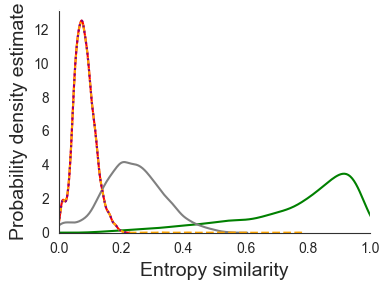

In [99]:

fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1['entropy_cont_raw'], label= 'Raw spectra', color = raw_color)
sns.kdeplot(sn1['entropy_cont_denoised'], label= 'Spectral denoising' ,color= sd_color)

sns.kdeplot(sn1['entropy_reduce'], label= 'MS Reduce' ,color= mr_color)
sns.kdeplot(sn1['entropy_dnl'], label= 'DNL denoising' ,color= dnl_color,linestyle = '--')
sns.kdeplot(sn1['entropy_thres'], label= '1% bp thresholding' ,color= thr_color, linestyle = ':')
ax.set_xlabel('Entropy similarity',size = 14)
ax.set_ylabel('Probability density estimate', size = 14)
ax.set_facecolor("white")
ax.set_xlim(0,1)
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
plt.legend([],[], frameon=False)
# ax.tick_params(labelsize=6)

fig.tight_layout()
plt.savefig(os.path.join(figs_dir, 'low_high_no_legend.png'))
# plt.savefig(os.path.join(figs_dir, 'low_high.png'))

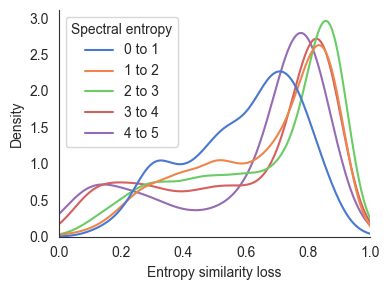

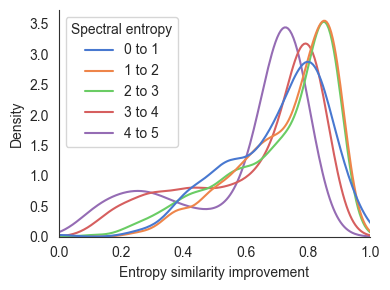

In [149]:
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1, x="entropy_loss", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False,
            hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5']
            )
# plt.legend( facecolor = 'white')
# sns.move_legend(ax, "upper left")
ax.set_xlabel('Entropy similarity loss')
fig.tight_layout()
ax.set_xlim(0,1)
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'low_high_entropy_loss.png'))
# ax.set_ylabel('Probability density estimate')

fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
# plt.legend(title='Spectral entropy', loc='upper right', labels=['0-1', '1-2','2-3','3-4','4-5'])
ax.set_xlabel('Entropy similarity improvement')
ax.set_xlim(0,1)
sns.kdeplot(sn1, x="entropy_gain", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False, hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5'])

# sns.kdeplot(sn1, x="entropy_gain", hue="level", multiple="layer",palette="pastel",common_norm=False,)
# plt.legend(title='Spectral entropy', loc='upper left', labels=['0-1', '1-2','2-3','3-4','4-5'], facecolor = 'white')
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'low_high_entropy_gain.png'))


# low middle

In [150]:
sn1 = read_df(os.path.join(master_dir, 'synthetic_noise_sn_0.1_10.csv'))
msms_thres = []
entropy_thres = []
msms_reduce = []
entropy_reduce = []
msms_dnl = []
entropy_dnl = []
for index, row in tqdm(sn1.iterrows(), total = len(sn1)):
    msms_temp = drf.threshold_denoising(row['msms_cont'], threshold=0.5)
    entropy_thres.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.ms_reduce(row['msms_cont'])
    entropy_reduce.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.dnl_denoising(row['msms_cont'])
    entropy_dnl.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
sn1['entropy_thres']=entropy_thres
sn1['entropy_reduce']=entropy_reduce
sn1['entropy_dnl']=entropy_dnl
sn1 = add_statistics(sn1)


done read in df


100%|██████████| 6106/6106 [00:48<00:00, 124.93it/s]


entropy gain for entropy 0-1 is:  0.5433244109153748
entropy gain for entropy 1-2 is:  0.5626237317919731
entropy gain for entropy 2-3 is:  0.522093340754509
entropy gain for entropy 3-4 is:  0.4555310606956482
entropy gain for entropy 4-5 is:  0.42059347033500677
entropy loss for entropy 0-1 is:  0.4355281889438629
entropy loss for entropy 1-2 is:  0.5005224272608757
entropy loss for entropy 2-3 is:  0.4898715317249298
entropy loss for entropy 3-4 is:  0.441062793135643
entropy loss for entropy 4-5 is:  0.4397724866867066


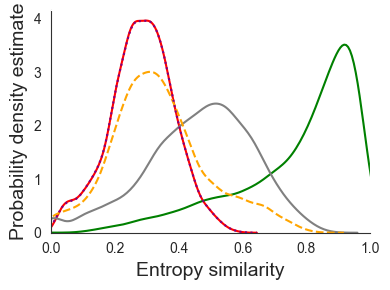

In [102]:
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1['entropy_cont_raw'], label= 'Raw spectra', color = raw_color)
sns.kdeplot(sn1['entropy_cont_denoised'], label= 'Spectral denoising' ,color= sd_color)

sns.kdeplot(sn1['entropy_reduce'], label= 'MS Reduce' ,color= mr_color)
sns.kdeplot(sn1['entropy_dnl'], label= 'DNL denoising' ,color= dnl_color,linestyle = '--')
sns.kdeplot(sn1['entropy_thres'], label= '1% bp thresholding' ,color= thr_color, linestyle = ':')
ax.set_xlabel('Entropy similarity',size = 14)
ax.set_ylabel('Probability density estimate', size = 14)
ax.set_facecolor("white")
ax.set_xlim(0,1)
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
plt.legend([],[], frameon=False)
# ax.tick_params(labelsize=6)

fig.tight_layout()
plt.savefig(os.path.join(figs_dir, 'low_middle_no_legend.png'))

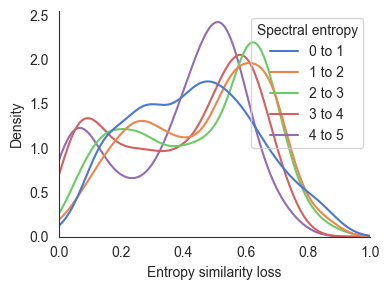

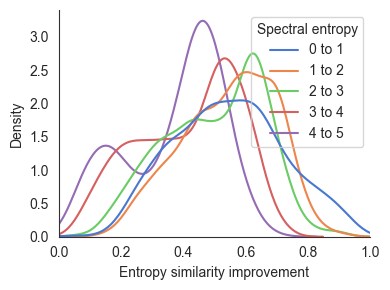

In [151]:
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1, x="entropy_loss", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False,
            hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5']
            )
# plt.legend( facecolor = 'white')
# sns.move_legend(ax, "upper left")
ax.set_xlabel('Entropy similarity loss')
fig.tight_layout()
ax.set_xlim(0,1)
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'low_middle_entropy_loss.png'))
# ax.set_ylabel('Probability density estimate')

fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
# plt.legend(title='Spectral entropy', loc='upper right', labels=['0-1', '1-2','2-3','3-4','4-5'])
ax.set_xlabel('Entropy similarity improvement')
ax.set_xlim(0,1)
sns.kdeplot(sn1, x="entropy_gain", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False, hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5'])

# sns.kdeplot(sn1, x="entropy_gain", hue="level", multiple="layer",palette="pastel",common_norm=False,)
# plt.legend(title='Spectral entropy', loc='upper left', labels=['0-1', '1-2','2-3','3-4','4-5'], facecolor = 'white')
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'low_middle_entropy_gain.png'))

# low low

In [ ]:
sn1 = read_df(os.path.join(master_dir, 'synthetic_noise_sn_0.1_2.csv'))
msms_thres = []
entropy_thres = []
msms_reduce = []
entropy_reduce = []
msms_dnl = []
entropy_dnl = []
for index, row in tqdm(sn1.iterrows(), total = len(sn1)):
    msms_temp = drf.threshold_denoising(row['msms_cont'], threshold=0.5)
    entropy_thres.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.ms_reduce(row['msms_cont'])
    entropy_reduce.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
    msms_temp = drf.dnl_denoising(row['msms_cont'])
    entropy_dnl.append(so.entropy_identity(msms_temp, row['library_peaks'], pmz=row['reference_precursor_mz']))
sn1['entropy_thres']=entropy_thres
sn1['entropy_reduce']=entropy_reduce
sn1['entropy_dnl']=entropy_dnl
sn1 = add_statistics(sn1)

In [6]:
sn1 = add_statistics(sn1)

entropy gain for entropy 0-1 is:  0.3801899552345276
entropy gain for entropy 1-2 is:  0.36651386320590973
entropy gain for entropy 2-3 is:  0.30804762244224543
entropy gain for entropy 3-4 is:  0.23786446452140808
entropy gain for entropy 4-5 is:  0.19862467050552368
entropy loss for entropy 0-1 is:  0.25688624382019043
entropy loss for entropy 1-2 is:  0.28535783290863037
entropy loss for entropy 2-3 is:  0.2648710459470749
entropy loss for entropy 3-4 is:  0.22129324078559875
entropy loss for entropy 4-5 is:  0.2139926552772522


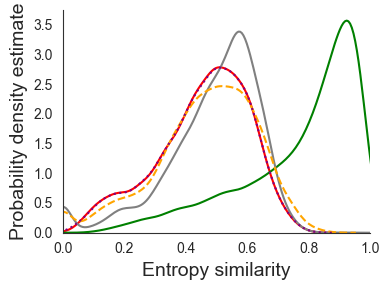

In [15]:
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1['entropy_cont_raw'], label= 'Raw spectra', color = raw_color)
sns.kdeplot(sn1['entropy_cont_denoised'], label= 'Spectral denoising' ,color= sd_color)

sns.kdeplot(sn1['entropy_reduce'], label= 'MS Reduce' ,color= mr_color)
sns.kdeplot(sn1['entropy_dnl'], label= 'DNL denoising' ,color= dnl_color,linestyle = '--')
sns.kdeplot(sn1['entropy_thres'], label= '1% bp thresholding' ,color= thr_color, linestyle = ':')
ax.set_xlabel('Entropy similarity',size = 14)
ax.set_ylabel('Probability density estimate', size = 14)
ax.set_facecolor("white")
ax.set_xlim(0,1)
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.legend([],[], frameon=False)
# ax.tick_params(labelsize=6)

fig.tight_layout()
plt.savefig(os.path.join(figs_dir, 'low_low_no_legend.png'))

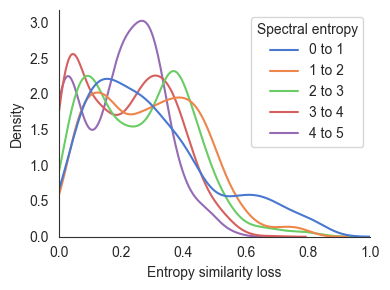

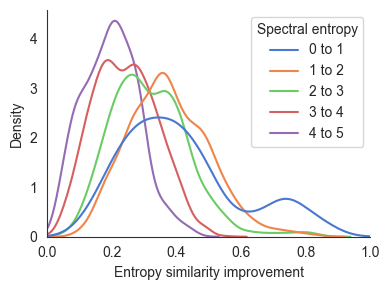

In [11]:
sns.set_style('white', {'legend.frameon':True})
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(sn1, x="entropy_loss", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False,
            hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5']
            )
# plt.legend( facecolor = 'white')
# sns.move_legend(ax, "upper left")
ax.set_xlabel('Entropy similarity loss')
fig.tight_layout()
ax.set_xlim(0,1)
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'low_low_entropy_loss.png'))
# ax.set_ylabel('Probability density estimate')

fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
# plt.legend(title='Spectral entropy', loc='upper right', labels=['0-1', '1-2','2-3','3-4','4-5'])
ax.set_xlabel('Entropy similarity improvement')
ax.set_xlim(0,1)
sns.kdeplot(sn1, x="entropy_gain", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False, hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5'])

# sns.kdeplot(sn1, x="entropy_gain", hue="level", multiple="layer",palette="pastel",common_norm=False,)
# plt.legend(title='Spectral entropy', loc='upper left', labels=['0-1', '1-2','2-3','3-4','4-5'], facecolor = 'white')
plt.grid(False)
plt.tight_layout()
ax.set_facecolor("white")
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(os.path.join(figs_dir, 'low_low_entropy_gain.png'))

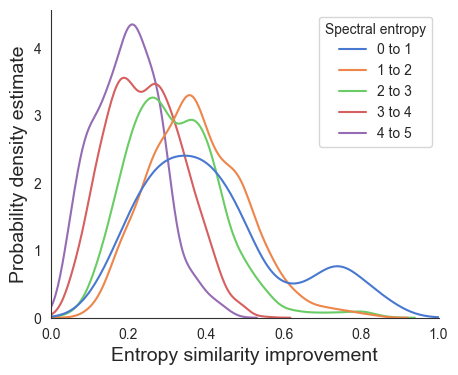

In [126]:
# fig = plt.figure(figsize = (5, 4))#43
# ax = fig.add_subplot()
# sns.kdeplot(sn1, x="entropy_loss", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False,
#             hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5']
#             )
# # plt.legend( facecolor = 'white')
# # sns.move_legend(ax, "upper left")
# ax.set_xlabel('Entropy similarity loss')
# fig.tight_layout()
# ax.set_xlim(0,1)
# plt.grid(False)
# plt.tight_layout()
# plt.legend(facecolor='white',fontsize="8")
# # ax.set_facecolor("white")
# plt.savefig(os.path.join(figs_dir, 'low_low_entropy_loss.png'))
# ax.set_ylabel('Probability density estimate')

fig = plt.figure(figsize = (5, 4))#43
ax = fig.add_subplot()
# plt.legend(title='Spectral entropy', loc='upper right', labels=['0-1', '1-2','2-3','3-4','4-5'])

ax.set_xlim(0,1)
sns.kdeplot(sn1, x="entropy_gain", hue="Spectral entropy",palette="muted", fill = False, multiple='layer',common_norm=False, hue_order = ['0 to 1','1 to 2', '2 to 3', '3 to 4', '4 to 5'])
sns.move_legend(ax, "upper right")
ax.set_ylabel('Probability density estimate', size = 14)
ax.set_xlabel('Entropy similarity improvement', size = 14)

# sns.kdeplot(sn1, x="entropy_gain", hue="level", multiple="layer",palette="pastel",common_norm=False,)
# plt.legend(title='Spectral entropy', loc='upper left', labels=['0-1', '1-2','2-3','3-4','4-5'], facecolor = 'white')
plt.grid(False)
# sns.set_style({'legend.frameon':False,'axes.facecolor': 'None'})
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
ax.spines[['right', 'top']].set_visible(False)
ax.set_facecolor("None")

plt.savefig(os.path.join(figs_dir, 'low_low_entropy_gain_enlarged.png'))